# TP de régression linéaire

**Crédits.** Ce TP est largement inspiré du scénario disponible sur Wikistat.

## 1. Introduction

### Objectif

L'objectif est d'améliorer la prévision déterministe (MOCAGE), calculée par les services de Météo France, de la concentration d'ozone dans certaines stations de prélèvement. Il s'agit d'un problème dit d'adaptation statistique ou post-traitement d'une prévision locale de modèles à trop grande échelle en s'aidant d'autre variables également gérées par MétéoFrance, mais à plus petite échelle (température, force du vent, etc.).

### Description des données 
Les données ont été extraites et mises en forme par le service concerné de Météo France. Elles sont décrites par les variables suivantes:
- JOUR : Type de jour (férié (1) ou pas (0) ;
- O3obs : Concentration d'ozone effectivement observée le lendemain à 17h locales correspondant souvent au maximum de pollution observée ;
- MOCAGE : Prévision de cette pollution obtenue par un modèle déterministe de mécanique des fluides (équation de Navier et Stockes);
- TEMPE : Température prévue par MétéoFrance pour le lendemain 17h ;
- RMH2O : Rapport d'humidité ;
- NO2 : Concentration en dioxyde d'azote ;
- NO : Concentration en monoxyde d'azote ;
- STATION : Lieu de l'observation (Aix-en-Provence, Rambouillet, Munchhausen, Cadarache et Plan de Cuques) ;
- VentMOD : Force du vent ;
- VentANG : Orientation du vent.

Ce sont des données bien codées et de petite taille. Elles présentent avant tout un caractère pédagogique.


## 2. Prise en main des données

Afin de charger et d'étudier les données, nous allons utiliser la librairie pandas pour bénéficier de la classe DataFrame.


### 2.1. Chargement des données

In [7]:
import pandas as pd
import numpy as np
from math import sqrt, log

# chargement des données
Ozone_DF = pd.read_csv('depSeuil.csv', sep = ',', header = 0)

# typage des données
Ozone_DF["STATION"] = pd.Categorical(Ozone_DF["STATION"], ordered = False)
Ozone_DF["JOUR"] = pd.Categorical(Ozone_DF["JOUR"], ordered = False)
Ozone_DF["O3obs"] = pd.DataFrame(Ozone_DF["O3obs"], dtype = float)

Ozone_DF.dtypes
Ozone_DF.head()

,JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
0,1,91.0,93.2,21.5,0.00847,1.602,0.424,Aix,9.5000,-0.64350
1,1,100.0,104.6,20.2,0.00881,2.121,0.531,Aix,8.0100,-0.04996
2,0,82.0,103.6,17.4,0.00951,1.657,0.467,Aix,9.3771,-0.12832
3,0,94.0,94.8,18.8,0.00855,2.350,0.701,Aix,9.4578,-0.34516
4,0,107.0,99.0,23.7,0.00731,1.653,0.452,Aix,7.8791,-0.41822


In [9]:
Ozone_DF[:1000]

,JOUR,O3obs,MOCAGE,TEMPE,RMH2O,NO2,NO,STATION,VentMOD,VentANG
0,1,91.0,93.2,21.5,0.00847,1.602,0.424,Aix,9.5000,-0.64350
1,1,100.0,104.6,20.2,0.00881,2.121,0.531,Aix,8.0100,-0.04996
2,0,82.0,103.6,17.4,0.00951,1.657,0.467,Aix,9.3771,-0.12832
3,0,94.0,94.8,18.8,0.00855,2.350,0.701,Aix,9.4578,-0.34516
4,0,107.0,99.0,23.7,0.00731,1.653,0.452,Aix,7.8791,-0.41822
...,...,...,...,...,...,...,...,...,...,...
995,1,114.0,160.5,24.9,0.00770,3.407,0.542,Pla,10.4652,-0.45510
996,1,111.0,137.1,22.2,0.00473,3.801,0.743,Pla,11.8119,-0.49394
997,0,103.0,180.7,24.6,0.00605,4.663,0.673,Pla,7.3348,0.19205
998,0,107.0,173.8,20.2,0.01053,1.557,0.195,Pla,5.0448,0.24017


In [5]:
Ozone_DF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1041 entries, 0 to 1040
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   JOUR     1041 non-null   category
 1   O3obs    1041 non-null   float64 
 2   MOCAGE   1041 non-null   float64 
 3   TEMPE    1041 non-null   float64 
 4   STATION  1041 non-null   category
 5   VentMOD  1041 non-null   float64 
 6   VentANG  1041 non-null   float64 
 7   SRMH2O   1041 non-null   float64 
 8   LNO2     1041 non-null   float64 
 9   LNO      1041 non-null   float64 
dtypes: category(2), float64(8)
memory usage: 67.5 KB


### 2.2. Exploration des données

#### Exploration uni-dimensionelle

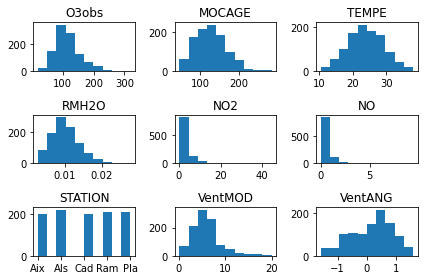

In [2]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows = 3, ncols = 3)

i_name = 0
            
for i in range(3):
    for j in range(3):
            i_name = i_name+1
            name_col = Ozone_DF.columns[i_name]
            axs[i, j].hist(Ozone_DF[name_col])
            axs[i, j].set_title(name_col)

fig.tight_layout()
plt.show()

#### Transformation du jeu de données

In [10]:
from math import sqrt, log

Ozone_DF["SRMH2O"] = Ozone_DF["RMH2O"].map(lambda x: sqrt(x))
Ozone_DF["LNO2"] = Ozone_DF["NO2"].map(lambda x: log(x))
Ozone_DF["LNO"] = Ozone_DF["NO"].map(lambda x: log(x))
del Ozone_DF["RMH2O"]
del Ozone_DF["NO2"]
del Ozone_DF["NO"]

In [11]:
Ozone_DF[:1000]

,JOUR,O3obs,MOCAGE,TEMPE,STATION,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,1,91.0,93.2,21.5,Aix,9.5000,-0.64350,0.092033,0.471253,-0.858022
1,1,100.0,104.6,20.2,Aix,8.0100,-0.04996,0.093862,0.751888,-0.632993
2,0,82.0,103.6,17.4,Aix,9.3771,-0.12832,0.097519,0.505009,-0.761426
3,0,94.0,94.8,18.8,Aix,9.4578,-0.34516,0.092466,0.854415,-0.355247
4,0,107.0,99.0,23.7,Aix,7.8791,-0.41822,0.085499,0.502592,-0.794073
...,...,...,...,...,...,...,...,...,...,...
995,1,114.0,160.5,24.9,Pla,10.4652,-0.45510,0.087750,1.225832,-0.612489
996,1,111.0,137.1,22.2,Pla,11.8119,-0.49394,0.068775,1.335264,-0.297059
997,0,103.0,180.7,24.6,Pla,7.3348,0.19205,0.077782,1.539659,-0.396010
998,0,107.0,173.8,20.2,Pla,5.0448,0.24017,0.102616,0.442761,-1.634756


**Question.** Quelles sont les transformations appliquées ci-dessus, et dans quel but ?

In [12]:
Ozone_Dum = pd.get_dummies(Ozone_DF[["JOUR", "STATION"]])
del Ozone_Dum["JOUR_0"]

Ozone_Quant = Ozone_DF[["MOCAGE", "TEMPE", "VentMOD", "VentANG", "SRMH2O", "LNO2", "LNO"]]

In [13]:
Ozone_Dum.head()

,JOUR_1,STATION_Aix,STATION_Als,STATION_Cad,STATION_Pla,STATION_Ram
0,1,1,0,0,0,0
1,1,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [14]:
Ozone_Quant.head()

,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,93.2,21.5,9.5000,-0.64350,0.092033,0.471253,-0.858022
1,104.6,20.2,8.0100,-0.04996,0.093862,0.751888,-0.632993
2,103.6,17.4,9.3771,-0.12832,0.097519,0.505009,-0.761426
3,94.8,18.8,9.4578,-0.34516,0.092466,0.854415,-0.355247
4,99.0,23.7,7.8791,-0.41822,0.085499,0.502592,-0.794073


**Question.** Quelles sont les transformations appliquées ci-dessus, et dans quel but ?

#### Exploration multi-dimensionnelle

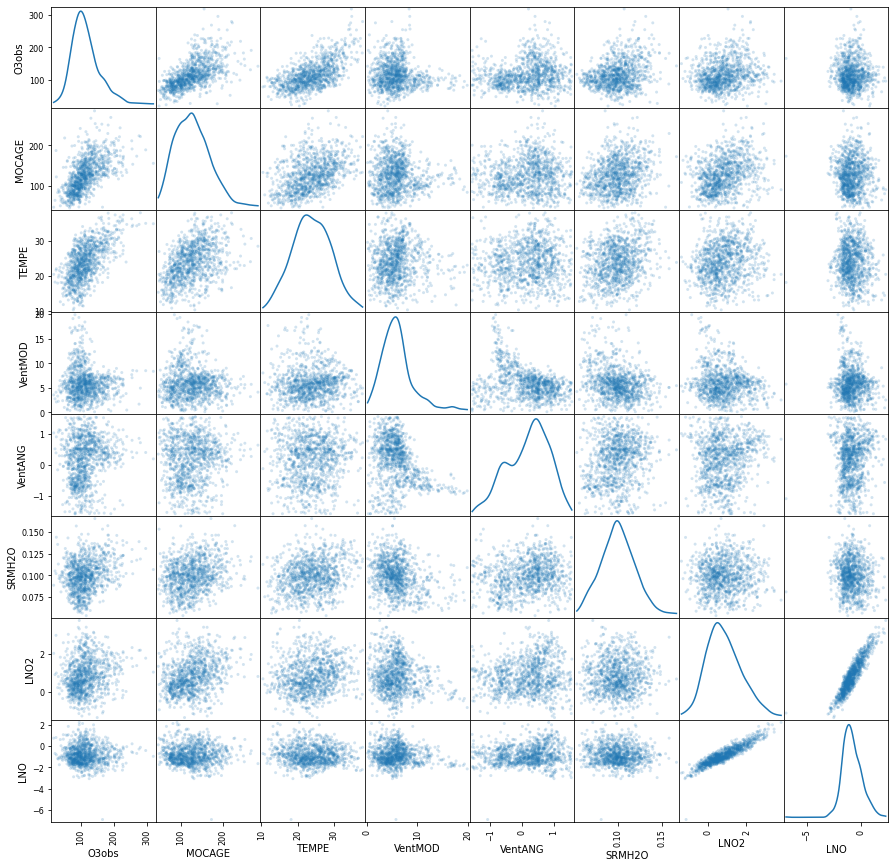

In [15]:
from pandas.plotting import scatter_matrix

scatter_matrix(Ozone_DF[["O3obs", "MOCAGE", "TEMPE", "VentMOD", "VentANG", "SRMH2O", "LNO2", "LNO"]], alpha=0.2, figsize=(15, 15), diagonal='kde')
plt.show()

### 2.3. Création de l'ensemble d'apprentissage / validation et de l'ensemble de test

In [18]:
X = pd.concat([Ozone_Dum, Ozone_Quant], axis = 1)
Y = Ozone_DF["O3obs"]

X.head()

,JOUR_1,STATION_Aix,STATION_Als,STATION_Cad,STATION_Pla,STATION_Ram,MOCAGE,TEMPE,VentMOD,VentANG,SRMH2O,LNO2,LNO
0,1,1,0,0,0,0,93.2,21.5,9.5000,-0.64350,0.092033,0.471253,-0.858022
1,1,1,0,0,0,0,104.6,20.2,8.0100,-0.04996,0.093862,0.751888,-0.632993
2,0,1,0,0,0,0,103.6,17.4,9.3771,-0.12832,0.097519,0.505009,-0.761426
3,0,1,0,0,0,0,94.8,18.8,9.4578,-0.34516,0.092466,0.854415,-0.355247
4,0,1,0,0,0,0,99.0,23.7,7.8791,-0.41822,0.085499,0.502592,-0.794073


In [19]:
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import StandardScaler  

X_1, X_2, Y_1, Y_2 = train_test_split(X, Y, train_size = 400, test_size = 200, random_state = 42)

X_av = X_1.to_numpy()
X_t = X_2.to_numpy()
Y_av = np.transpose([Y_1.to_numpy()])
Y_t = np.transpose([Y_2.to_numpy()])

**Remarque.** Scikit-learn fonctionne avec des numpy array. Nous allons donc utiliser les indices des colonnes:

0. JOUR
1. STATION_Aix 
2. STATION_Als 
3. STATION_Cad 
4. STATION_Pla
5. STATION_Ram
6. MOCAGE
7. TEMPE
8. VentMOD
9. VentANG
10. SRMH2O
11. LNO2
12. LNO

## 3. Régression linéaire univariée

### 3.1. Relation unidimensionelle 

On étudie la qualité de la relation $\hat{Y} = X$, où $\hat{Y}$ est le vecteur de prédiction de l'O3 observée et $X$ le vecteur des prévisions de l'O3 observée calculée par Météo France.

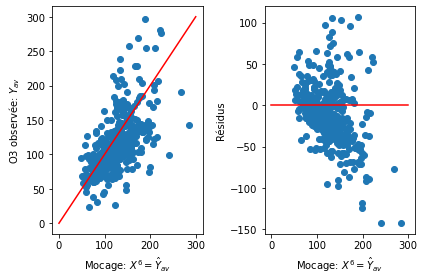

Coefficient de détermination : 0.1747287689862833


In [20]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

fig, axs = plt.subplots(nrows = 1, ncols = 2)

axs[0].plot(X_av[:,[6]], Y_av, 'o')
axs[0].plot([0, 300], [0, 300], 'r')
axs[0].set_xlabel('Mocage: $X^6 = \hat{Y}_{av}$')
axs[0].set_ylabel('O3 observée: $Y_{av}$')

axs[1].plot(X_av[:,[6]], Y_av - X_av[:,[6]], 'o')
axs[1].plot([0, 300], [0, 0], 'r')
axs[1].set_xlabel('Mocage: $X^6= \hat{Y}_{av}$')
axs[1].set_ylabel('Résidus')

fig.tight_layout()
plt.show()

print("Coefficient de détermination :", r2_score(Y_av, X_av[:,[6]]))

**Question.** Commentez les résultats.

### 3.2. Régression linéaire ordinaire 

On étudie la qualité de la relation $\hat{Y} = X\beta + \epsilon$, où $\hat{Y}$ est le vecteur de prédiction de l'O3 observée et $X$ le vecteur des prévisions de l'O3 observée calculée par Météo France.

Coefficient de régression : 
 [[0.63990869]]



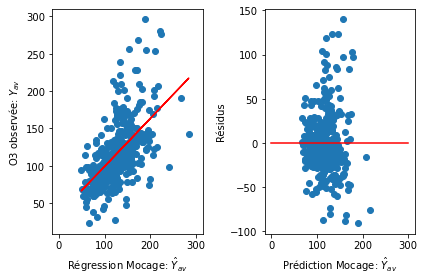

Erreur quadratique (learning set) : 1125.92
Coefficient de détermination (learning set) : 0.35


In [21]:
from sklearn import linear_model

ols = linear_model.LinearRegression()
ols.fit(X_av[:,[6]], Y_av)
Y_hat_av = ols.predict(X_av[:,[6]])

print("Coefficient de régression : \n", ols.coef_)
print()

fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex = True)

axs[0].plot(X_av[:,[6]], Y_av, 'o')
axs[0].plot(X_av[:,[6]], Y_hat_av, 'r-')
#axs[0].set_ylim(0, 300)
axs[0].set_xlabel('Régression Mocage: $\hat{Y}_{av}$')
axs[0].set_ylabel('O3 observée: $Y_{av}$')

axs[1].plot(Y_hat_av, Y_av - Y_hat_av, 'o')
axs[1].plot([0, 300], [0, 0], 'r')
axs[1].set_xlabel('Prédiction Mocage: $\hat{Y}_{av}$')
axs[1].set_ylabel('Résidus')

fig.tight_layout()
plt.show()

print("Erreur quadratique (learning set) : %.2f" % mean_squared_error(Y_av, Y_hat_av))
print("Coefficient de détermination (learning set) : %.2f" % r2_score(Y_av, Y_hat_av))

**Questions.**

1. Pourquoi n'y a-t-il qu'un seul coefficient ?
2. Commentez les résultats.

## 4. Régression linéaire multivariée

### 4.1. Régression linéaire ordinaire

**Exercice.** 
1. Appliquez une régression linéaire sur l'ensemble d'apprentissage $(X_{av}, Y_{av})$ et évaluez la qualité des résultats en comparantc eux obtenus sur $(X_{av}, Y_{av})$ et sur $(X_{t}, Y_{t})$. Commentez.
2. Observez les coefficients de régression et commentez.

### 4.2. Régression linéaire pénalisée : Ridge

**Question**.  Rappelez le modèle de la régression ridge et le comportement attendu.

Nous allons observer sur l'ensemble d'apprentissage, pour 3 valeurs de alpha ($\lambda$ dans le cours), le comportement de la regression ridge sur les coefficients.

#### Modèle 1

Erreur quadratique (learning set) : 744.16
Coefficient de détermination (learning set) : 0.57


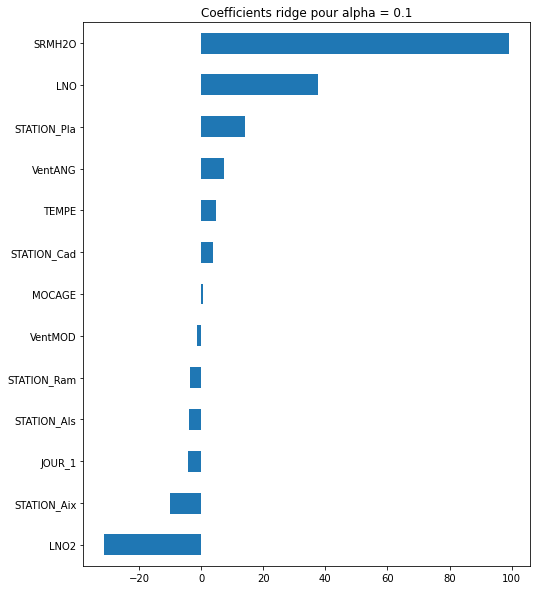

In [22]:
r_a01 = linear_model.Ridge(alpha = 0.1)
model_r_a01 = r_a01.fit(X_av, Y_av)
Y_hat_av_r01 = r_a01.predict(X_av)
Y_hat_t_r01 = r_a01.predict(X_t)

print("Erreur quadratique (learning set) : %.2f" % mean_squared_error(Y_av, Y_hat_av_r01))
print("Coefficient de détermination (learning set) : %.2f" % r2_score(Y_av, Y_hat_av_r01))

coef = pd.Series(model_r_a01.coef_[0], index =  X.columns)
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients ridge pour alpha = 0.1")
plt.show()

#### Modèle 2

Erreur quadratique (learning set) : 751.10
Coefficient de détermination (learning set) : 0.56


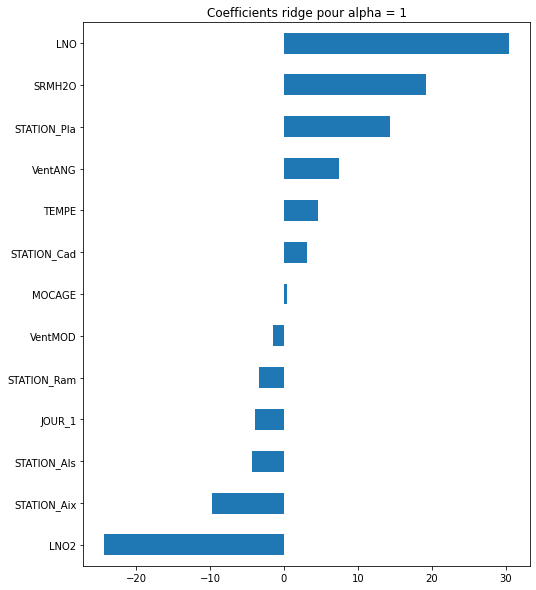

In [23]:
r_a1 = linear_model.Ridge(alpha = 1)
model_r_a1 = r_a1.fit(X_av, Y_av)
Y_hat_av_r1 = r_a1.predict(X_av)
Y_hat_t_r1 = r_a1.predict(X_t)

print("Erreur quadratique (learning set) : %.2f" % mean_squared_error(Y_av, Y_hat_av_r1))
print("Coefficient de détermination (learning set) : %.2f" % r2_score(Y_av, Y_hat_av_r1))

coef = pd.Series(model_r_a1.coef_[0], index =  X.columns)
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients ridge pour alpha = 1")
plt.show()

#### Modèle 3

Erreur quadratique (learning set) : 765.31
Coefficient de détermination (learning set) : 0.56


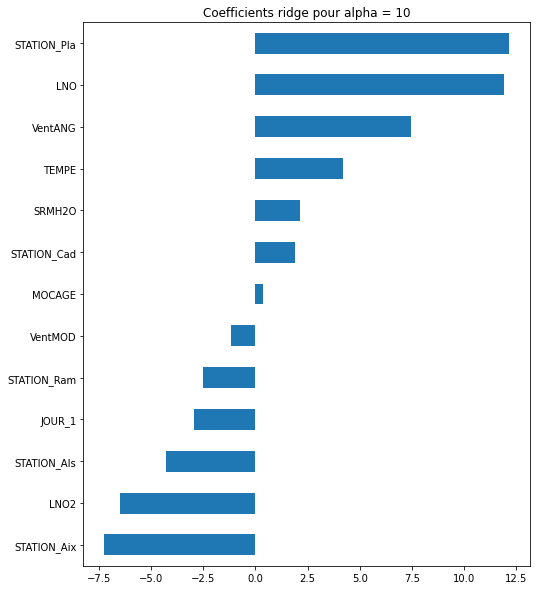

In [25]:
r_a10 = linear_model.Ridge(alpha = 10)
model_r_a10 = r_a10.fit(X_av, Y_av)
Y_hat_av_r10 = r_a10.predict(X_av)
Y_hat_t_r10 = r_a10.predict(X_t)

print("Erreur quadratique (learning set) : %.2f" % mean_squared_error(Y_av, Y_hat_av_r10))
print("Coefficient de détermination (learning set) : %.2f" % r2_score(Y_av, Y_hat_av_r10))

coef = pd.Series(model_r_a10.coef_[0], index =  X.columns)
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients ridge pour alpha = 10")
plt.show()

**Question**. Commentez l'évolution du comportement sur les coefficients. Comment l'expliquez vous ?

**Exercice**. Visualisez globalement l'évolution des coefficients en fonction de alpha. Vous pouvez vous aider de la [documentation sur chemin de régularisation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_ridge_path.html#sphx-glr-auto-examples-linear-model-plot-ridge-path-py).

**Exercice**. Mettez en place une procédure d'apprentissage rigoureuse pour trouver le paramètre alpha optimal de la régression ridge. 

**Remarque**. Pensez à regarder les références fournies en cours (cf. mail et annonce sur le moodle) ainsi que la [documentation sur le modèle Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html).

### 4.3. Régression linéaire pénalisée : Lasso

**Question**. Rappelez le modèle de la régression lasso et le comportement attendu.

**Exercice**. Mettez en place une procédure d'apprentissage rigoureuse pour trouver le paramètre alpha optimal dans la régression lasso. Pensez à regarder la [documentation sur le modèle Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html).

## 5. Travail à rendre

Vous devez rendre sur le moodle, pour le dimanche 12/12/21, une archive nom_prenom.(g)zip ou nom_prenom.tgz inférieure à 10 Mo, contenant :

5.1. Un notebook python complétant les réponses aux questions et les exercices de ce nootebook.

5.2. Une étude sur le jeu de données [Parkinson speech](https://archive.ics.uci.edu/ml/datasets/Parkinson+Speech+Dataset+with++Multiple+Types+of+Sound+Recordings), en utilisant $Y$ = UPDRS, avec :
- Une synthèse de 4 pages au format pdf contenant les pricipales informations.
- Le notebook associé.